### Linear Regression, and Regularization

In [1]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv("historical_data.csv")

In [3]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [6]:
# convert string datetime columns to datetime objects
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])

# create a new column for delivery time in minutes by subtracting the order time from the delivery time
data['delivery_time_minutes'] = (data['actual_delivery_time'] - data['created_at']) / np.timedelta64(1, 'm')

In [7]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time_minutes
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,62.983333
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,67.066667
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,29.683333
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,51.250000
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,39.833333


## Data Cleaning

In [8]:
# Check for missing values in the dataset
print('Missing values in each column:')
print(data.isnull().sum())

# Let's drop rows with missing values in our key target variable
data = data.dropna(subset=['delivery_time_minutes'])

# Fill missing numeric values with mean values
numeric_cols = data.select_dtypes(include=['float64']).columns
for col in numeric_cols:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].mean())

# Fill missing categorical values with the most frequent category
if data['store_primary_category'].isnull().sum() > 0:
    data['store_primary_category'] = data['store_primary_category'].fillna(data['store_primary_category'].mode()[0])

# Verify cleaning results
print('\nRemaining missing values after cleaning:')
print(data.isnull().sum())

Missing values in each column:
market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
delivery_time_minutes                               7
dtype: int64

Remaining missing values after cleani

## Feature Engineering

In [9]:
# Extract time features from created_at
data['hour_of_day'] = data['created_at'].dt.hour
data['day_of_week'] = data['created_at'].dt.dayofweek  # 0 is Monday, 6 is Sunday
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # Weekend flag

# Calculate order complexity features
data['price_per_item'] = data['subtotal'] / data['total_items']
data['price_range'] = data['max_item_price'] - data['min_item_price']

# Calculate operational load metrics
data['dasher_load'] = data['total_outstanding_orders'] / (data['total_onshift_dashers'] + 1)  # Adding 1 to avoid division by zero
data['busy_dasher_ratio'] = data['total_busy_dashers'] / (data['total_onshift_dashers'] + 1)  # Adding 1 to avoid division by zero

# Display new features
data[['hour_of_day', 'day_of_week', 'is_weekend', 'price_per_item', 'price_range', 'dasher_load', 'busy_dasher_ratio']].head()

,hour_of_day,day_of_week,is_weekend,price_per_item,price_range,dasher_load,busy_dasher_ratio
0,22,4,0,860.25,682,0.617647,0.411765
1,21,1,0,1900.00,0,1.000000,1.000000
2,20,3,0,1900.00,0,0.000000,0.000000
3,21,1,0,1150.00,1200,1.000000,0.500000
4,2,6,1,1300.00,500,1.285714,0.857143


## Outlier Detection and Removal

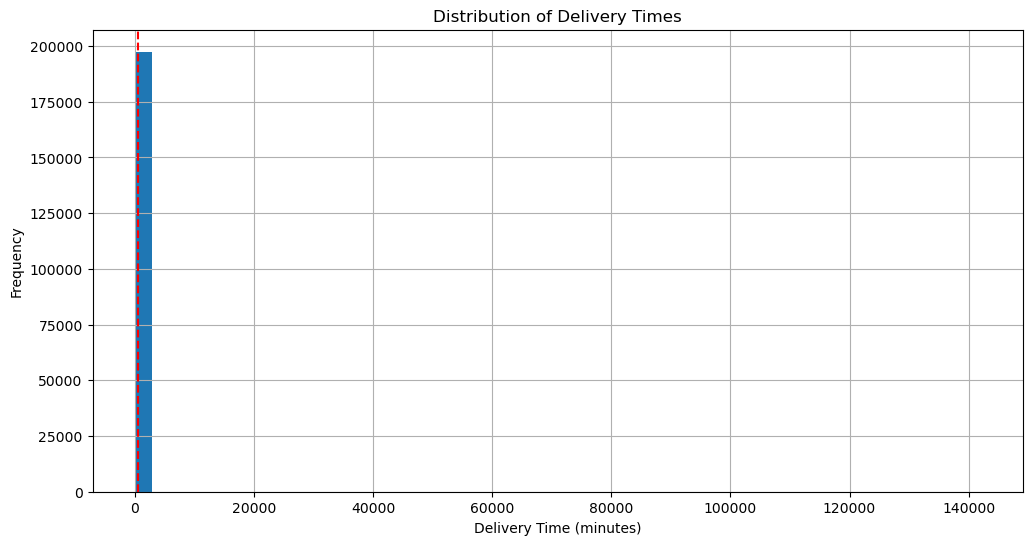

Maximum delivery time: 141947.65 minutes
99th percentile: 107.91333333333314 minutes
95th percentile: 81.2 minutes
Number of orders taking > 2 hours: 1090
Number of orders taking > 10 hours: 11


In [15]:
# Check the distribution of delivery times to identify outliers

plt.figure(figsize=(12, 6))
plt.hist(data['delivery_time_minutes'], bins=50)
plt.axvline(x=600, color='r', linestyle='--')  # 10 hours = 600 minutes
plt.title('Distribution of Delivery Times')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display extreme values
print("Maximum delivery time:", data['delivery_time_minutes'].max(), "minutes")
print("99th percentile:", data['delivery_time_minutes'].quantile(0.99), "minutes")
print("95th percentile:", data['delivery_time_minutes'].quantile(0.95), "minutes")
print("Number of orders taking > 2 hours:", (data['delivery_time_minutes'] > 120).sum())
print("Number of orders taking > 10 hours:", (data['delivery_time_minutes'] > 600).sum())

Removed 127 extreme outliers
Dataset size before: 197410, after: 197283


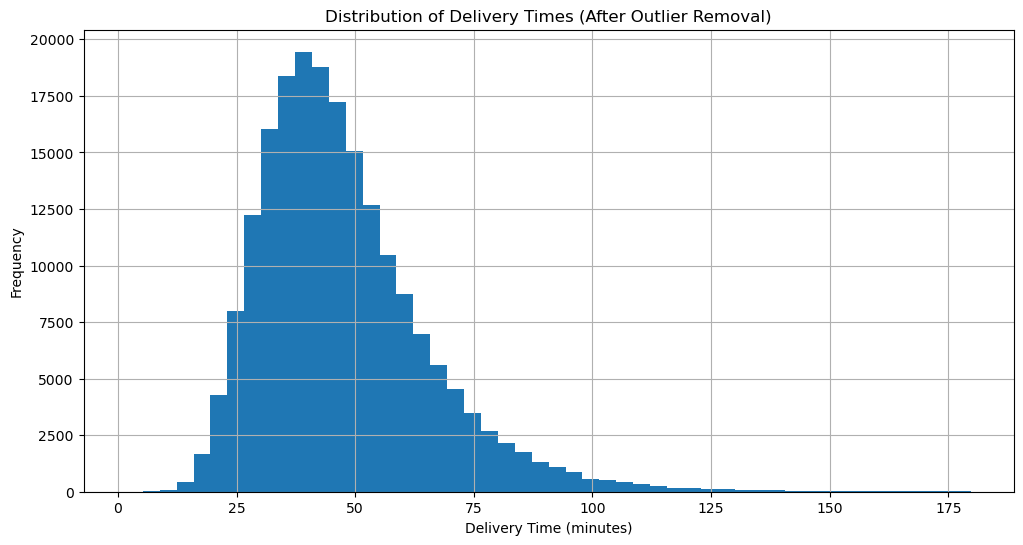

In [17]:
# Remove extreme outliers (over 10 hours delivery time)
data_cleaned = data[data['delivery_time_minutes'] <= 180]

print(f"Removed {len(data) - len(data_cleaned)} extreme outliers")
print(f"Dataset size before: {len(data)}, after: {len(data_cleaned)}")

# Update our working dataset
data = data_cleaned

# Visualize the distribution after removing outliers
plt.figure(figsize=(12, 6))
plt.hist(data['delivery_time_minutes'], bins=50)
plt.title('Distribution of Delivery Times (After Outlier Removal)')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Prepare Data for Linear Regression

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Select features for the model
features = ['market_id', 'store_id', 'store_primary_category', 'order_protocol', 'total_items', 
           'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 
           'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
           'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration',
           'hour_of_day', 'day_of_week', 'is_weekend', 'price_per_item', 'price_range',
           'dasher_load', 'busy_dasher_ratio']

# Create a copy for modeling to avoid modifications to the original dataframe
model_data = data.copy()

# Handle non-numeric categorical features
categorical_features = ['store_primary_category']
numeric_features = [f for f in features if f not in categorical_features]

# Drop rows with missing values in any of these features to ensure a clean dataset for modeling
model_data = model_data.dropna(subset=features)

# Create X (features) and y (target)
X = model_data[features]
y = model_data['delivery_time_minutes']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (157826, 21)
Testing set size: (39457, 21)


In [ ]:
# Import additional preprocessing tools
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

# Function to replace infinite values with NaN
def replace_inf(X):
    return np.where(np.isinf(X), np.nan, X)

# Create preprocessing pipeline with handling for outliers, infinities, and scaling
num_pipeline = Pipeline(steps=[
    ('replace_inf', FunctionTransformer(replace_inf)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create full preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a linear regression pipeline
linear_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
linear_reg_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = linear_reg_pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f} minutes")
print(f"Mean Squared Error: {mse:.2f} minutes²")
print(f"Root Mean Squared Error: {rmse:.2f} minutes")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error: 11.42 minutes
Mean Squared Error: 241.73 minutes²
Root Mean Squared Error: 15.55 minutes
R² Score: 0.2507


/opt/anaconda3/envs/NN/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Model Visualization and Analysis

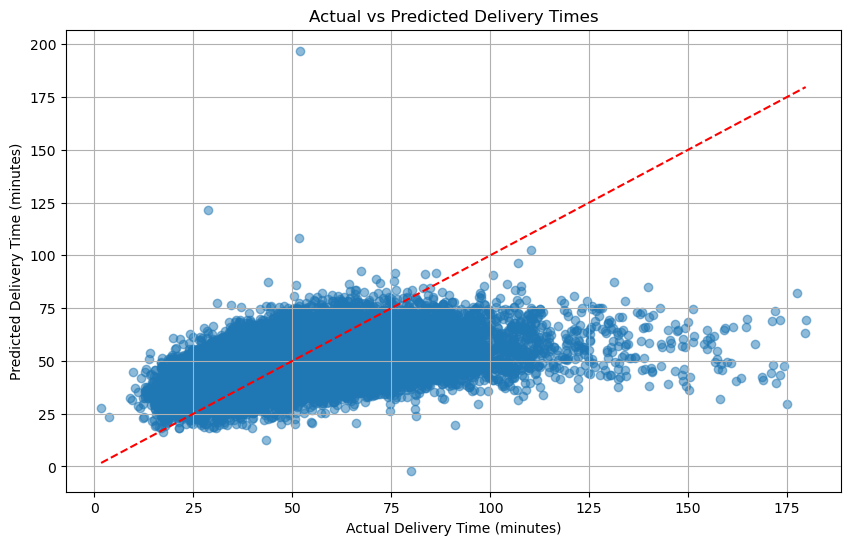

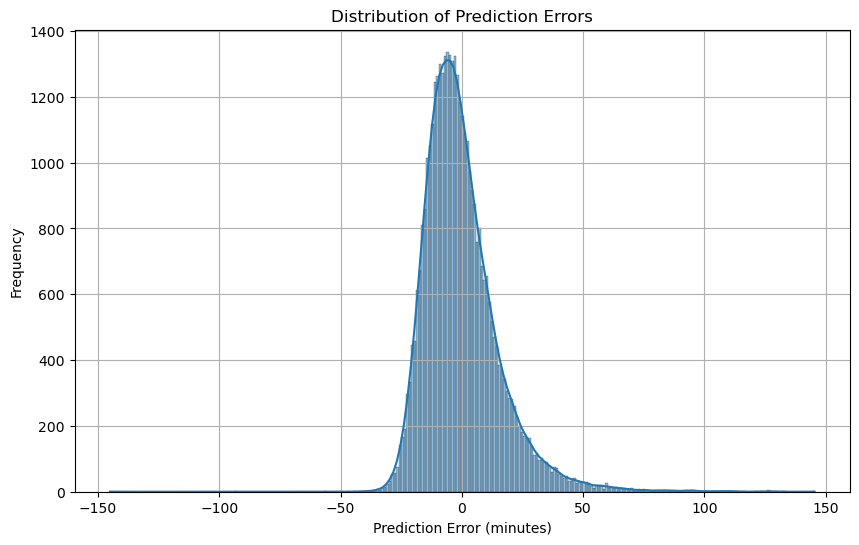

In [21]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Delivery Time (minutes)')
plt.ylabel('Predicted Delivery Time (minutes)')
plt.title('Actual vs Predicted Delivery Times')
plt.grid(True)
plt.show()

# Visualize prediction error distribution
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()

## Regularization: Ridge and Lasso Regression

In [22]:
# Ridge Regression with alpha=1.0
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

ridge_pipeline.fit(X_train, y_train)
ridge_pred = ridge_pipeline.predict(X_test)

# Lasso Regression with alpha=0.1
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.1))
])

lasso_pipeline.fit(X_train, y_train)
lasso_pred = lasso_pipeline.predict(X_test)

# Evaluate all models
models = {
    'Linear Regression': y_pred,
    'Ridge Regression': ridge_pred,
    'Lasso Regression': lasso_pred
}

print("Model Comparison:")
for name, predictions in models.items():
    mae = mean_absolute_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)
    print(f"{name}:")
    print(f"  MAE: {mae:.2f} minutes")
    print(f"  RMSE: {rmse:.2f} minutes")
    print(f"  R²: {r2:.4f}")

Model Comparison:
Linear Regression:
  MAE: 11.42 minutes
  RMSE: 15.55 minutes
  R²: 0.2507
Ridge Regression:
  MAE: 11.42 minutes
  RMSE: 15.55 minutes
  R²: 0.2508
Lasso Regression:
  MAE: 11.45 minutes
  RMSE: 15.60 minutes
  R²: 0.2456


/opt/anaconda3/envs/NN/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/NN/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/NN/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Feature Importance Analysis

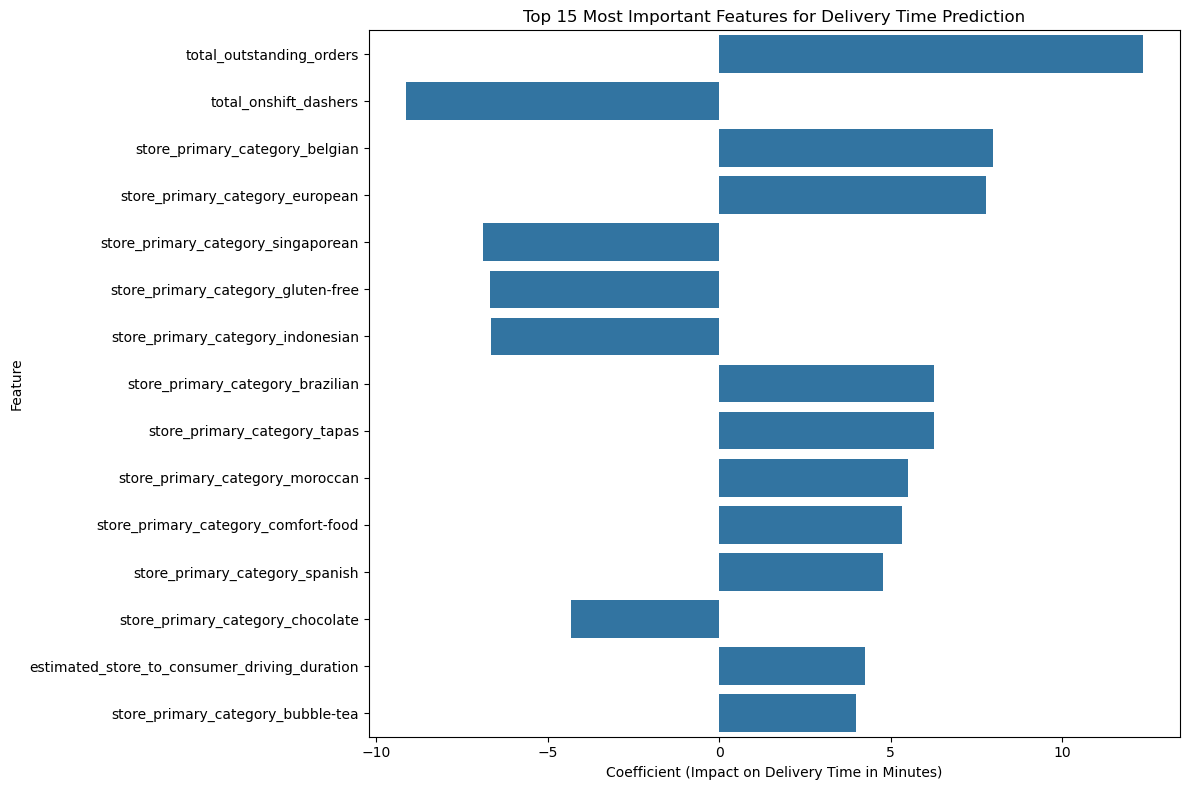

In [23]:
# Get feature names after preprocessing
import numpy as np

# Fit preprocessor to get feature names
preprocessor.fit(X_train)

# Get feature names for numeric columns (directly used)
num_feature_names = numeric_features

# Get feature names for one-hot encoded columns
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

# Combine all feature names
all_feature_names = np.append(num_feature_names, cat_feature_names)

# Get coefficients from the linear regression model
linear_model = linear_reg_pipeline.named_steps['regressor']
coefficients = linear_model.coef_

# Create a DataFrame to display feature importances
# Note: Coefficients length might not match feature names exactly due to preprocessing
# Only use the number of coefficients we have
feature_importance = pd.DataFrame({
    'Feature': all_feature_names[:len(coefficients)],
    'Coefficient': coefficients
})

# Sort by absolute coefficient value
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False).head(15)

# Plot top features
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Top 15 Most Important Features for Delivery Time Prediction')
plt.xlabel('Coefficient (Impact on Delivery Time in Minutes)')
plt.tight_layout()
plt.show()